# Cervix EDA

In this competition we have a multi-class classification problem with **three** classes. We are asked, given an image, to identify the cervix type.

From the data description:

*In this competition, you will develop algorithms to correctly classify cervix types based on cervical images. These different types of cervix in our data set are all considered normal (not cancerous), but since the transformation zones aren't always visible, some of the patients require further testing while some don't. This decision is very important for the healthcare provider and critical for the patient. Identifying the transformation zones is not an easy task for the healthcare providers, therefore, an algorithm-aided decision will significantly improve the quality and efficiency of cervical cancer screening for these patients.*

The submission format is asking for a probability for each of the three different cervix types.

In this notebook we will be looking at:

* basic dataset stats like number of samples per class, image sizes
* different embeddings of RGB image space
* pairwise distances and a clustermap of images in RGB space
* (linear) model selection with basic multi class evaluation metrics.

**If you like this kernel, please give an upvote, thanks! :)**

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread, imshow
import cv2

%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from glob import glob
import sklearn
from sklearn.preprocessing import LabelEncoder,Normalizer,StandardScaler
from sklearn import svm

In [2]:
from common_functions import *

In [3]:
from subprocess import check_output
print(check_output(["ls", "./train"]).decode("utf8"))

Type_1
Type_2
Type_3



We are given training images for each of cervix types. Lets first count them for each class.

In [29]:
basepath = './train/'

all_cervix_images = []

for path in sorted(glob(basepath + "*")):
    cervix_type = path.split("/")[-1]
    cervix_images = sorted(glob(basepath + cervix_type + "/*"))
    all_cervix_images = all_cervix_images + cervix_images

all_cervix_images = pd.DataFrame({'imagepath': all_cervix_images})
all_cervix_images['filetype'] = all_cervix_images.apply(lambda row: row.imagepath.split(".")[-1], axis=1)
all_cervix_images['type'] = all_cervix_images.apply(lambda row: row.imagepath.split("/")[-2], axis=1)
all_cervix_images.head()

,imagepath,filetype,type
0,./train/Type_1/0.jpg,jpg,Type_1
1,./train/Type_1/10.jpg,jpg,Type_1
2,./train/Type_1/1013.jpg,jpg,Type_1
3,./train/Type_1/1014.jpg,jpg,Type_1
4,./train/Type_1/1019.jpg,jpg,Type_1


## Image types

Now that we have the data in a handy dataframe we can do a few aggregations on the data. Let us first see how many images there are for each cervix type and which file types they have.

All files are in JPG format and Type 2 is the most common one with a little bit more than 50% in the training data in total, Type 1 on the other hand has a little bit less than 20% in the training data.

We have a total of 1481 images in the whole dataset


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



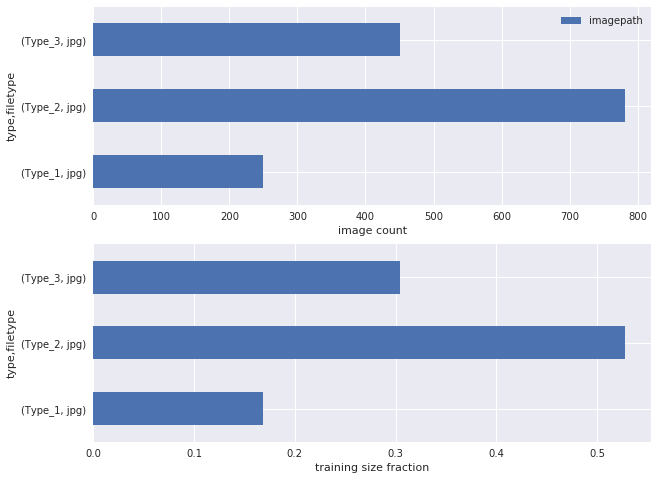

In [30]:
print('We have a total of {} images in the whole dataset'.format(all_cervix_images.shape[0]))
type_aggregation = all_cervix_images.groupby(['type', 'filetype']).agg('count')
type_aggregation_p = type_aggregation.apply(lambda row: 1.0*row['imagepath']/all_cervix_images.shape[0], axis=1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

type_aggregation.plot.barh(ax=axes[0])
axes[0].set_xlabel("image count")
type_aggregation_p.plot.barh(ax=axes[1])
axes[1].set_xlabel("training size fraction")

Now, lets read the files for each type to get an idea about how the images look like.

The images seem to vary alot in they formats, the first two samples have only a circular area with the actual image, the last sample has the image in a rectangle.

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans



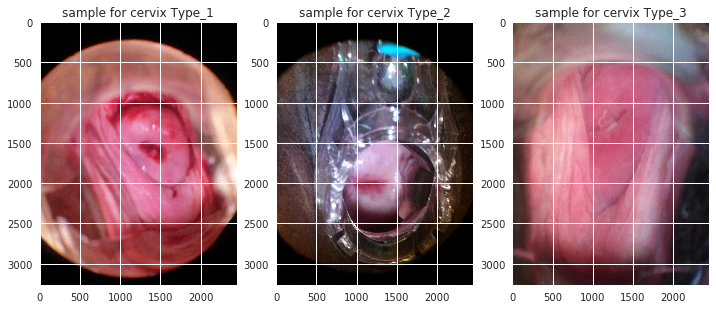

In [13]:
fig = plt.figure(figsize=(12,8))

i = 1
for t in all_cervix_images['type'].unique():
    ax = fig.add_subplot(1,3,i)
    i+=1
    f = all_cervix_images[all_cervix_images['type'] == t]['imagepath'].values[0]
    plt.imshow(cv2.cvtColor(cv2.imread(f,flags=cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB))
    plt.title('sample for cervix {}'.format(t))

## Image dimensions

Now, in order to get an idea of how many different shapes of images by class there are, lets have a look at. To reduce runtime, take only a subsample per class.

In [ ]:
from collections import defaultdict

images = defaultdict(list)

for t in all_cervix_images['type'].unique():
    sample_counter = 0
    for _, row in all_cervix_images[all_cervix_images['type'] == t].iterrows():
        #print('reading image {}'.format(row.imagepath))
        try:
            img = cv2.cvtColor(cv2.imread(row.imagepath),cv2.COLOR_BGR2RGB)
            sample_counter +=1
            images[t].append(img)
        except:
            print('image read failed for {}'.format(row.imagepath))
        if sample_counter > 200:
            break

In [ ]:
images.keys()

In [ ]:
len(images["Type_3"])

In [ ]:
dfs = []
for t in all_cervix_images['type'].unique():
    t_ = pd.DataFrame(
        {
            'nrows': list(map(lambda i: i.shape[0], images[t])),
            'ncols': list(map(lambda i: i.shape[1], images[t])),
            'nchans': list(map(lambda i: i.shape[2], images[t])),
            'type': t
        }
    )
    dfs.append(t_)

shapes_df = pd.concat(dfs, axis=0)
shapes_df_grouped = shapes_df.groupby(by=['nchans', 'ncols', 'nrows', 'type']).size().reset_index().sort_values(['type', 0], ascending=False)
shapes_df_grouped

All of the images in our sample have three channels, we can ignore this information for now. Now lets build a barplot to get an idea of the distribution of image dimensions by cervix type.

# Load training images

In [78]:
def transform_image(img, rescaled_dim, to_gray=False):
    resized = cv2.resize(img, (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR)

    if to_gray:
        resized = cv2.cvtColor(resized, cv2.COLOR_RGB2GRAY).astype('float')
    else:
        resized = resized.astype('float')

    normalized = cv2.normalize(resized, None, 0.0, 1.0, cv2.NORM_MINMAX)
    timg = normalized.reshape(1, np.prod(normalized.shape))

    return timg/np.linalg.norm(timg)

rescaled_dim = 100

all_images = []
all_image_types = []

for t in all_cervix_images['type'].unique():
    all_images = all_images + images[t]
    all_image_types = all_image_types + len(images[t])*[t]

# - normalize each uint8 image to the value interval [0, 1] as float image
# - rgb to gray
# - downsample image to rescaled_dim X rescaled_dim
# - L2 norm of each sample = 1
gray_all_images_as_vecs = [transform_image(img, rescaled_dim) for img in all_images]

gray_imgs_mat = np.array(gray_all_images_as_vecs).squeeze()
all_image_types = np.array(all_image_types)
gray_imgs_mat.shape, all_image_types.shape

((603, 30000), (603,))

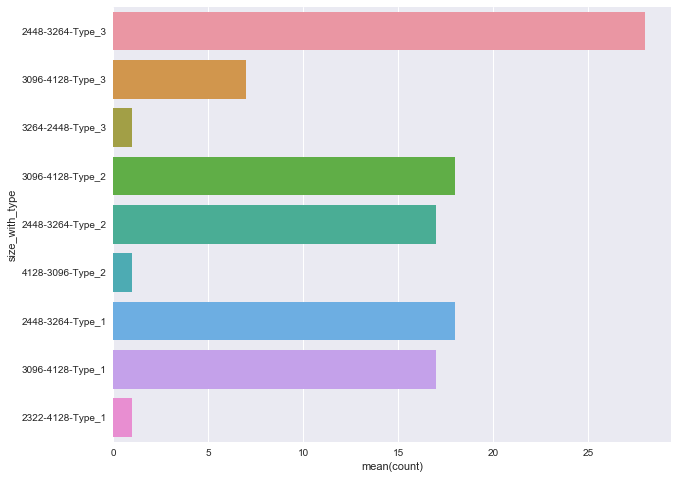

In [79]:
shapes_df_grouped['size_with_type'] = shapes_df_grouped.apply(lambda row: '{}-{}-{}'.format(row.ncols, row.nrows, row.type), axis=1)
shapes_df_grouped = shapes_df_grouped.set_index(shapes_df_grouped['size_with_type'].values)
shapes_df_grouped['count'] = shapes_df_grouped[[0]]

plt.figure(figsize=(10,8))
#shapes_df_grouped['count'].plot.barh(figsize=(10,8))
sns.barplot(x="count", y="size_with_type", data=shapes_df_grouped)

The image on the left has quite a lot of blue in it which I would not expect to be present in the majority of samples. I think it is a good representation of maximally dissimilar.

In [13]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations #18
pix_per_cell = 16# HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = False # HOG features on or off
#y_start_stop = [400, 720] # Min and max in y to search in slide_window()


def load_train_data(samples=10):

# Read in cars and notcars
    type_1 = glob('train/Type_1/*.jpg')
    type_2 = glob('train/Type_2/*.jpg')
    type_3 = glob('train/Type_3/*.jpg')
    type_1_features = extract_features(type_1[0:samples], color_space=color_space, 
                                       spatial_size=spatial_size, hist_bins=hist_bins, 
                                       orient=orient, pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                       hist_feat=hist_feat, hog_feat=hog_feat)
    type_2_features = extract_features(type_2[0:samples], color_space=color_space, 
                                       spatial_size=spatial_size, hist_bins=hist_bins, 
                                       orient=orient, pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                       hist_feat=hist_feat, hog_feat=hog_feat)

    type_3_features = extract_features(type_3[0:samples], color_space=color_space, 
                                       spatial_size=spatial_size, hist_bins=hist_bins, 
                                       orient=orient, pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                       hist_feat=hist_feat, hog_feat=hog_feat)    

#    return type_1_features,type_2_features,type_3_features

    X = np.vstack((type_1_features, type_2_features,type_3_features)).astype(np.float64)  

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.zeros(len(type_1_features)), np.ones(len(type_2_features)),2*np.ones(len(type_3_features))))
    
    return scaled_X,y,X_scaler


In [14]:
y=np.hstack((np.zeros(250), np.ones(500),2*np.ones(450)))
#X,y,X_scaler=load_train_data(500)

In [15]:
y.shape

(1200,)

----------

# Model Selection

Now that we've established a basic idea about the data, let's do the most straightforward approach, where we take the resized color images and labels and train a, most likely quite heavily regularized, linear model like logistic regression on it.

It is quite important to understand that we only have read a few training instances, 108, and have thousands of dimensions. To be able to cope with that we'll most likely end up using L1 regularization.

For the multi-class problem we are faced with here, we'll use standard approach of OVR (one vs rest), meaning we will train three models where each of them is designed to distinguish class 1, 2 and 3 from the others respectively.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((804, 3168), (396, 3168), (804,), (396,))

In [21]:
y_train, y_test

(array([ 2.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,
         0.,  0.,  2.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  2.,
         0.,  1.,  1.,  2.,  2.,  1.,  1.,  2.,  1.,  2.,  1.,  2.,  2.,
         1.,  1.,  1.,  2.,  1.,  2.,  0.,  2.,  1.,  1.,  2.,  1.,  0.,
         2.,  0.,  1.,  0.,  0.,  0.,  2.,  2.,  2.,  2.,  2.,  0.,  1.,
         2.,  0.,  2.,  1.,  2.]),
 array([ 0.,  1.,  1.,  1.,  1.,  2.,  2.,  1.,  0.,  0.,  0.,  0.,  2.,
         2.,  2.,  0.,  2.,  0.,  0.,  0.,  2.,  1.,  0.,  2.,  1.,  2.,
         0.,  1.,  1.,  0.,  2.,  0.,  2.,  2.,  0.]))

In [28]:
1e2

100.0

In [31]:
#clf = LogisticRegression()
clf=svm.SVC(probability=True)
grid = {
    'C':[1e-1, 1, 1e1],
    'gamma': [0.2, 0.45, 0.7,1,10.0],
}
cv = GridSearchCV(clf, grid, scoring='neg_log_loss', n_jobs=-1, verbose=1)
cv.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.5min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [0.01, 1, 100.0], 'gamma': [0.2, 0.45, 0.7, 1, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=1)

In [32]:
for i in range(1, len(cv.cv_results_['params'])+1):
    rank = cv.cv_results_['rank_test_score'][i-1]
    s = cv.cv_results_['mean_test_score'][i-1]
    sd = cv.cv_results_['std_test_score'][i-1]
    params = cv.cv_results_['params'][i-1]
    print("{0}. Mean validation neg log loss: {1:.6f} (std: {2:.6f}) - {3}".format(
        rank,
        s,
        sd,
        params
    ))

11. Mean validation neg log loss: -1.061514 (std: 0.000834) - {'C': 0.01, 'gamma': 0.2}
11. Mean validation neg log loss: -1.061514 (std: 0.000834) - {'C': 0.01, 'gamma': 0.45}
13. Mean validation neg log loss: -1.061669 (std: 0.000792) - {'C': 0.01, 'gamma': 0.7}
14. Mean validation neg log loss: -1.061843 (std: 0.000812) - {'C': 0.01, 'gamma': 1}
14. Mean validation neg log loss: -1.061843 (std: 0.000812) - {'C': 0.01, 'gamma': 10.0}
6. Mean validation neg log loss: -1.061072 (std: 0.000824) - {'C': 1, 'gamma': 0.2}
4. Mean validation neg log loss: -1.061071 (std: 0.000823) - {'C': 1, 'gamma': 0.45}
4. Mean validation neg log loss: -1.061071 (std: 0.000823) - {'C': 1, 'gamma': 0.7}
2. Mean validation neg log loss: -1.061070 (std: 0.000824) - {'C': 1, 'gamma': 1}
2. Mean validation neg log loss: -1.061070 (std: 0.000824) - {'C': 1, 'gamma': 10.0}
10. Mean validation neg log loss: -1.061082 (std: 0.000833) - {'C': 100.0, 'gamma': 0.2}
8. Mean validation neg log loss: -1.061078 (std: 0.

In [33]:
y_test_hat_p = cv.predict_proba(X_test)

In [34]:
sklearn.metrics.log_loss(y_test, y_test_hat_p)

1.0561210510329053

## Confusion matrix

The confusion matrix is a standard analysis tool in binary and multi-class classification where in each entry **C_{i,j}** corresponds to the number of samples that have true class label **i** and are predicted as **j**.

We can see that our models have a great problem with confusing class zero with class two.

In [40]:
pd.DataFrame({"label":y_test}).label.value_counts()

1.0    170
2.0    145
0.0     81
Name: label, dtype: int64

In [35]:
from sklearn.metrics import confusion_matrix

y_test_hat = cv.predict(X_test)
y_test_prob = cv.predict_proba(X_test)
data = [
    go.Heatmap(
        z=confusion_matrix(y_test, y_test_hat),
        x=[0, 1, 2],
        y=[0, 1, 2],
        colorscale='Viridis',
        text = True ,
        opacity = 1.0
    )
]

layout = go.Layout(
    title='Test Confusion matrix',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' ),
    width = 900, height = 700,
    
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

# Test Set

In [53]:
test_images = glob('test/*.jpg')
test_image_df=pd.DataFrame(pd.DataFrame({'imagepath': test_images}))

In [46]:
def load_test_data(X_scaler):
    test = glob('test/*.jpg')
    test_features = extract_features(test, color_space=color_space, 
                                       spatial_size=spatial_size, hist_bins=hist_bins, 
                                       orient=orient, pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                       hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((test_features)).astype(np.float64)  

    # Fit a per-column scaler
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    return scaled_X


In [50]:
test_imgs_mat[0,:]

array([ 0.82252477,  0.83523938,  0.77196454, ..., -0.20459526,
       -0.12452705, -0.05900446])

In [47]:
test_imgs_mat = load_test_data(X_scaler)
test_imgs_mat.shape

(512, 3168)

In [51]:
preds=cv.predict_proba(test_imgs_mat)

In [52]:
preds.shape

(512, 3)

In [54]:
test_image_df["Type_1"]=preds[:,0]
test_image_df["Type_2"]=preds[:,1]
test_image_df["Type_3"]=preds[:,2]

In [55]:
func=lambda x: x.split("/")[-1]
test_image_df["image_name"]=test_image_df["imagepath"].apply(func)

In [56]:
test_image_df

,imagepath,Type_1,Type_2,Type_3,image_name
0,test/49.jpg,0.208432,0.412153,0.379415,49.jpg
1,test/433.jpg,0.208432,0.412153,0.379415,433.jpg
2,test/70.jpg,0.208432,0.412153,0.379415,70.jpg
3,test/72.jpg,0.208432,0.412153,0.379415,72.jpg
4,test/502.jpg,0.208432,0.412153,0.379415,502.jpg
5,test/448.jpg,0.208432,0.412153,0.379415,448.jpg
6,test/504.jpg,0.208432,0.412153,0.379415,504.jpg
7,test/500.jpg,0.208432,0.412153,0.379415,500.jpg
8,test/488.jpg,0.208432,0.412153,0.379415,488.jpg
9,test/101.jpg,0.208432,0.412153,0.379415,101.jpg


In [57]:
#test_image_df[["image_name","Type_1","Type_2","Type_3"]].to_csv("first_submission.csv",index=False)
test_image_df[["image_name","Type_1","Type_2","Type_3"]].to_csv("third_submission.csv",index=False)